In [1]:
import numpy as np
import math
from itertools import product

def infinity_norm_average(matrix, n):
    """Compute the average infinity norm of matrix-vector products for all vectors in the Hamming cube {-1, 1}^n."""
    hamming_cube = product([-1, 1], repeat=n)
    norms = []

    for vector in hamming_cube:
        # Compute the matrix-vector product
        product_result = np.dot(matrix, vector)

        # Compute the infinity norm of the product
        infinity_norm = np.linalg.norm(product_result, ord=np.inf)
        norms.append(infinity_norm)

        max_entry_index = np.argmax(np.abs(product_result))  # Index of the largest entry by absolute value

    return np.mean(norms)

def monte_carlo_infinity_norm_average(matrix, n, samples=None):
    """
    Approximate the average infinity norm of matrix-vector products for
    randomly sampled vectors in the Hamming cube {-1, 1}^n.

    Parameters:
        matrix (numpy.ndarray): The input matrix.
        n (int): The dimension of the Hamming cube (number of columns in the matrix).
        samples (int, optional): The number of random samples to draw. Defaults to d^2.

    Returns:
        double: The approximate average infinity norm.
    """
    d = matrix.shape[1]
    if samples is None:
        samples = d  # Default number of samples
    norms = []
    for i in range(samples):
        # Randomly sample a vector from the Hamming cube {-1, 1}^n
        vector = np.random.choice([-1, 1], size=n)
        # Compute the matrix-vector product
        product_result = np.dot(matrix, vector)
        infinity_norm = np.linalg.norm(product_result, ord=np.inf)
        norms.append(infinity_norm)
    return np.mean(norms)

In [4]:
class TreeNode:
    def __init__(self):
        self.left = None
        self.right = None

def build_complete_binary_tree(n):
    # Total number of nodes in a complete binary tree with n leaves
    total_nodes = 2 * n - 1
    nodes = [TreeNode() for _ in range(total_nodes)]

    for i in range((total_nodes - 1) // 2):
        nodes[i].left = nodes[2 * i + 1]
        nodes[i].right = nodes[2 * i + 2]

    return nodes[0]

def get_root_to_leaf_paths(node, current_path, all_paths):
    if node is None:
        return
    if node.left is None and node.right is None:
        all_paths.append(current_path.copy())
        return
    if node.left:
        current_path.append(-1)
        get_root_to_leaf_paths(node.left, current_path, all_paths)
        current_path.pop()
    if node.right:
        current_path.append(1)
        get_root_to_leaf_paths(node.right, current_path, all_paths)
        current_path.pop()

def construct_matrix_from_tree(n):
    root = build_complete_binary_tree(n)
    all_paths = []
    get_root_to_leaf_paths(root, [1], all_paths)  # Start with edge to root labeled as 1

    matrix = []
    for path in all_paths:
        if len(path) < n:
            path.extend([0] * (n - len(path)))
        matrix.append(path)
    row_norms = np.linalg.norm(matrix, axis=1, keepdims=True)  # Compute L2 norms of rows
    matrix = matrix / row_norms
    return matrix

In [3]:
def generate_random_simplex(n):
    """Generate n+1 random vectors in R^n with entries in {-1, 1}, append 1, and normalize."""
    # Generate n+1 random vectors with entries in {-1, 1}
    random_vectors = np.random.choice([-1, 1], size=(n+1, n+1))

    # Normalize each vector in L2 norm
    norms = np.linalg.norm(random_vectors, axis=1)
    random_vectors = random_vectors / norms[:, np.newaxis]

    return random_vectors

In [7]:
import os, sys
def hadamard(n):
    path = os.path.join('/content/drive/MyDrive/bad-science/', f'bad_science.{n}.npy')
    if not os.path.isfile(path):
        print(f"Error: File not found: {path}")
        sys.exit(1)

    mat = np.sqrt(n)*np.load(path)
    return mat

In [8]:

import numpy as np

# known Hadamard orders ≤ 252
_HADAMARD_ORDERS = [
     1,   2,   4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,
    52,  56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104,
   108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156, 160,
   164, 168, 172, 176, 180, 184, 188, 192, 196, 200, 204, 208, 212, 216,
   220, 224, 228, 232, 236, 240, 244, 248, 252
]

def next_hadamard_order(n: int) -> int:
    """
    Return the smallest Hadamard order m >= n.
    Assumes n <= 252 and that such an m exists in _HADAMARD_ORDERS.
    """
    for m in _HADAMARD_ORDERS:
        if m >= n:
            return m
    raise ValueError(f"No Hadamard order ≥ {n} found (n must be ≤ 252).")

def orthonormal_almost_hadamard(n: int) -> np.ndarray:
    """
    Construct an n×n orthonormal matrix whose entries all satisfy
    |Q[i,j]| = (1 + O(1/n)) / sqrt(n), by truncating and orthonormalizing
    a Hadamard matrix of order m ≥ n.

    Parameters
    ----------
    n : int
        Dimension (must be ≤ 252).

    Returns
    -------
    Q : np.ndarray, shape (n, n)
        An orthonormal matrix (rows orthonormal) with nearly-flat entries.
    """
    # 1) pick the embedding size m
    m = next_hadamard_order(n)

    # 2) get the m×m ±1–Hadamard matrix
    H = hadamard(m)              # entries in {+1, -1}, with H @ H.T = m I_m

    # 3) truncate to the top-left n×n block and scale
    U = H[:n, :n].astype(float)  # keep only first n rows & cols
    U /= np.sqrt(m)              # now each row has norm sqrt(n/m) = 1 - O(1/n)

    # 4) orthonormalize via QR
    #    np.linalg.qr returns Q with orthonormal columns,
    #    but since QQ^T = I, the rows are orthonormal as well.
    Q, _ = np.linalg.qr(U)

    return Q

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

max_n = 21  # Going beyond 20 becomes computationally expensive
ns = list(range(3, max_n + 1))

baseline_diff = []
simplex = []
random = []
difference = []

for n in ns:
    print(f"Processing n={n}...")
    baseline_diff.append(1/np.log(n + 1))
    weight = orthonormal_almost_hadamard(n)
    hadamard_beta = infinity_norm_average(weight, n)
    simplex.append(hadamard_beta)
    random_weight = generate_random_simplex(n)
    random_beta = infinity_norm_average(random_weight, n + 1)
    random.append(random_beta)
    difference.append(hadamard_beta - random_beta)

Processing n=3...
Processing n=4...
Processing n=5...
Processing n=6...
Processing n=7...
Processing n=8...
Processing n=9...
Processing n=10...
Processing n=11...
Processing n=12...
Processing n=13...
Processing n=14...
Processing n=15...
Processing n=16...
Processing n=17...
Processing n=18...
Processing n=19...
Processing n=20...
Processing n=21...


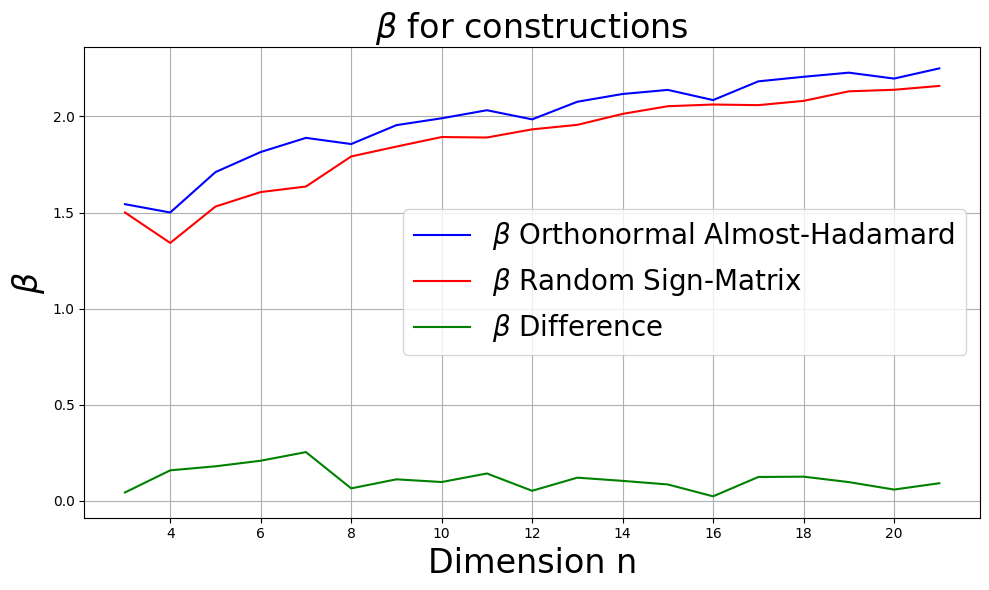

In [38]:
# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ns, simplex, 'b', label=r'$\beta$ Orthonormal Almost-Hadamard')
ax.plot(ns, random,  'r', label=r'$\beta$ Random Sign-Matrix')
ax.plot(ns, difference,  'g', label=r'$\beta$ Difference')
# Force x-axis to integer ticks
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.set_xlabel('Dimension n', fontsize=24)
ax.set_ylabel(r'$\beta$', fontsize=24)
ax.set_title(r'$\beta$ for constructions', fontsize=24)
ax.legend(fontsize=20)

fig.tight_layout()
ax.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt

max_n = 252
ns = list(range(1, max_n + 1))

baseline_diff = []
simplex = []
random = []
difference = []
tree = []

# Lists for ranks
rank_simplex = []
rank_random = []
rank_tree = []

print(len(ns))
for n in ns:
    print(f"Processing n={n}...")

    baseline_diff.append(1 / np.log(n + 1))

    # Orthonormal Almost-Hadamard
    weight = orthonormal_almost_hadamard(n)
    hadamard_beta = monte_carlo_infinity_norm_average(weight, n)
    simplex.append(hadamard_beta)
    rank_simplex.append(np.linalg.matrix_rank(weight))

    # Random simplex
    random_weight = generate_random_simplex(n)
    random_beta = monte_carlo_infinity_norm_average(random_weight, n + 1)
    random.append(random_beta)
    rank_random.append(np.linalg.matrix_rank(random_weight))

    difference.append(hadamard_beta - random_beta)

    # Subcube decomposition
    matrix_tree = construct_matrix_from_tree(n + 1)
    beta_tree = monte_carlo_infinity_norm_average(matrix_tree, n + 1)
    tree.append(beta_tree)
    rank_tree.append(np.linalg.matrix_rank(matrix_tree))

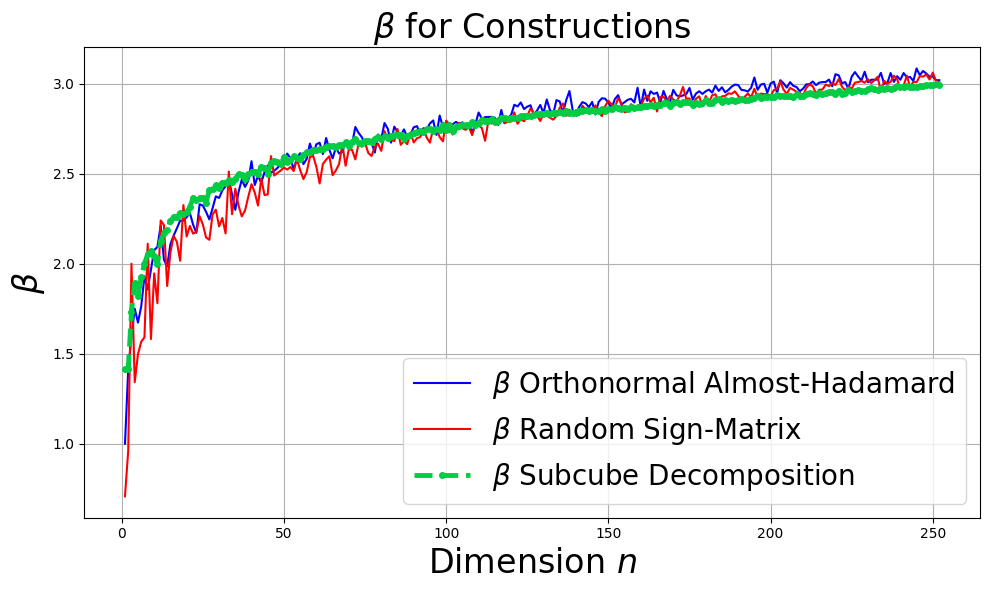

In [30]:

# Plot β-values
plt.figure(figsize=(10, 6))
plt.plot(ns, simplex, 'b', label=r'$\beta$ Orthonormal Almost-Hadamard')
plt.plot(ns, random, 'r', label=r'$\beta$ Random Sign-Matrix')
plt.plot(ns, tree, color='#00cc44', linestyle='--', linewidth=3.5,
         marker='o', markersize=4, label=r'$\beta$ Subcube Decomposition')
plt.xlabel('Dimension $n$', fontsize=24)
plt.ylabel(r'$\beta$', fontsize=24)
plt.title(r'$\beta$ for Constructions', fontsize=24)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

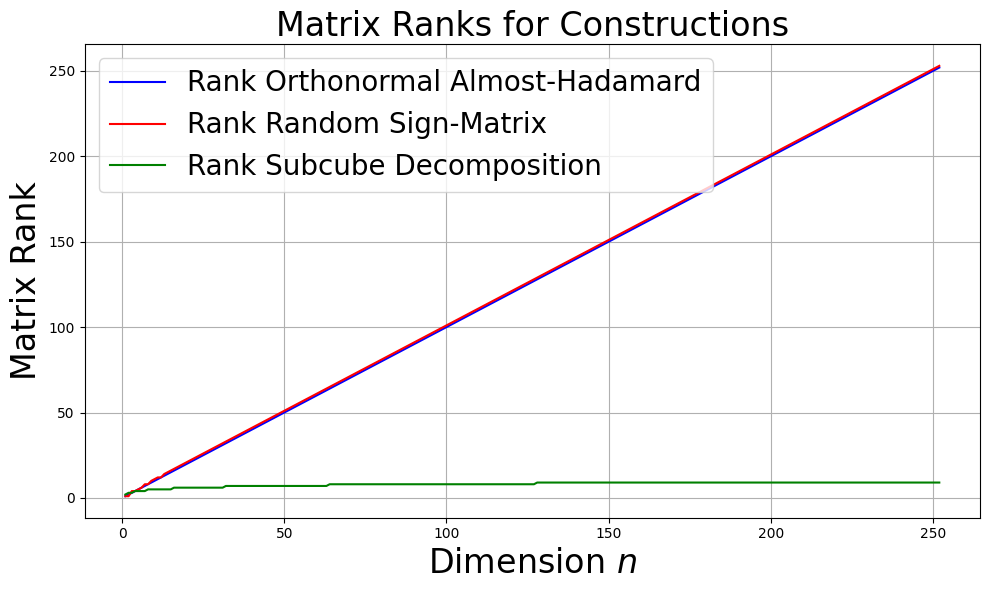

In [31]:

# Plot ranks
plt.figure(figsize=(10, 6))
plt.plot(ns, rank_simplex, 'b', label='Rank Orthonormal Almost-Hadamard')
plt.plot(ns, rank_random, 'r', label='Rank Random Sign-Matrix')
plt.plot(ns, rank_tree, 'g', label='Rank Subcube Decomposition')
plt.xlabel('Dimension $n$', fontsize=24)
plt.ylabel('Matrix Rank', fontsize=24)
plt.title('Matrix Ranks for Constructions', fontsize=24)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

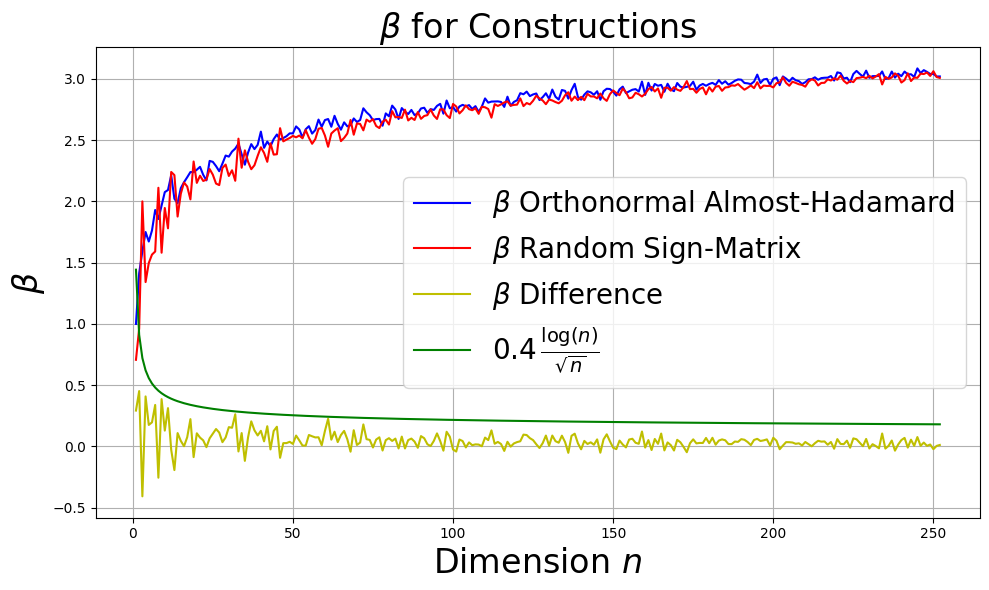

In [32]:
plt.figure(figsize=(10, 6))

asymptotic_difference_estimate = [0.4*((np.log(n)**(2/2))/(n**(1/2))) for n in ns]

plt.figure(figsize=(10, 6))
plt.plot(ns, simplex, 'b', label=r'$\beta$ Orthonormal Almost-Hadamard')
plt.plot(ns, random,  'r', label=r'$\beta$ Random Sign-Matrix')
plt.plot(ns, difference,  'y', label=r'$\beta$ Difference')
plt.plot(ns, baseline_diff, 'g', label = r'$0.4 \,\frac{\log(n)}{\sqrt{n}}$')

plt.xlabel('Dimension $n$', fontsize=24)
plt.ylabel(r'$\beta$', fontsize=24)
plt.title(r'$\beta$ for Constructions', fontsize=24)
plt.legend(fontsize=20)
plt.grid(True)
plt.tight_layout()
plt.show()